In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load dataset
df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

C:\Users\parth\AppData\Local\Temp\ipykernel_14220\2768379667.py:2: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")


# Univariate Analysis

In this phase, we examine each variable independently to understand its distribution, data quality, and overall behavior. Univariate analysis helps us identify patterns such as skewness, outliers, missing values, and unusual value concentrations. These observations are critical in credit risk modeling because:

- They highlight the need for transformations (e.g., log scaling, binning).
- They reveal potential data quality issues that could affect model performance.
- They help us understand which variables may carry meaningful predictive power for default.
- They ensure we maintain transparency and interpretability, which is important for regulated PD models.

For **numerical features**, we analyze the distribution using histograms and boxplots to detect skew or outliers.  
For **categorical features**, we plot frequency distributions to understand value concentration and sparsity.

This analysis sets the foundation for target-based risk analysis (default rate by feature) and feature selection in later stages.


## Categorical Variables

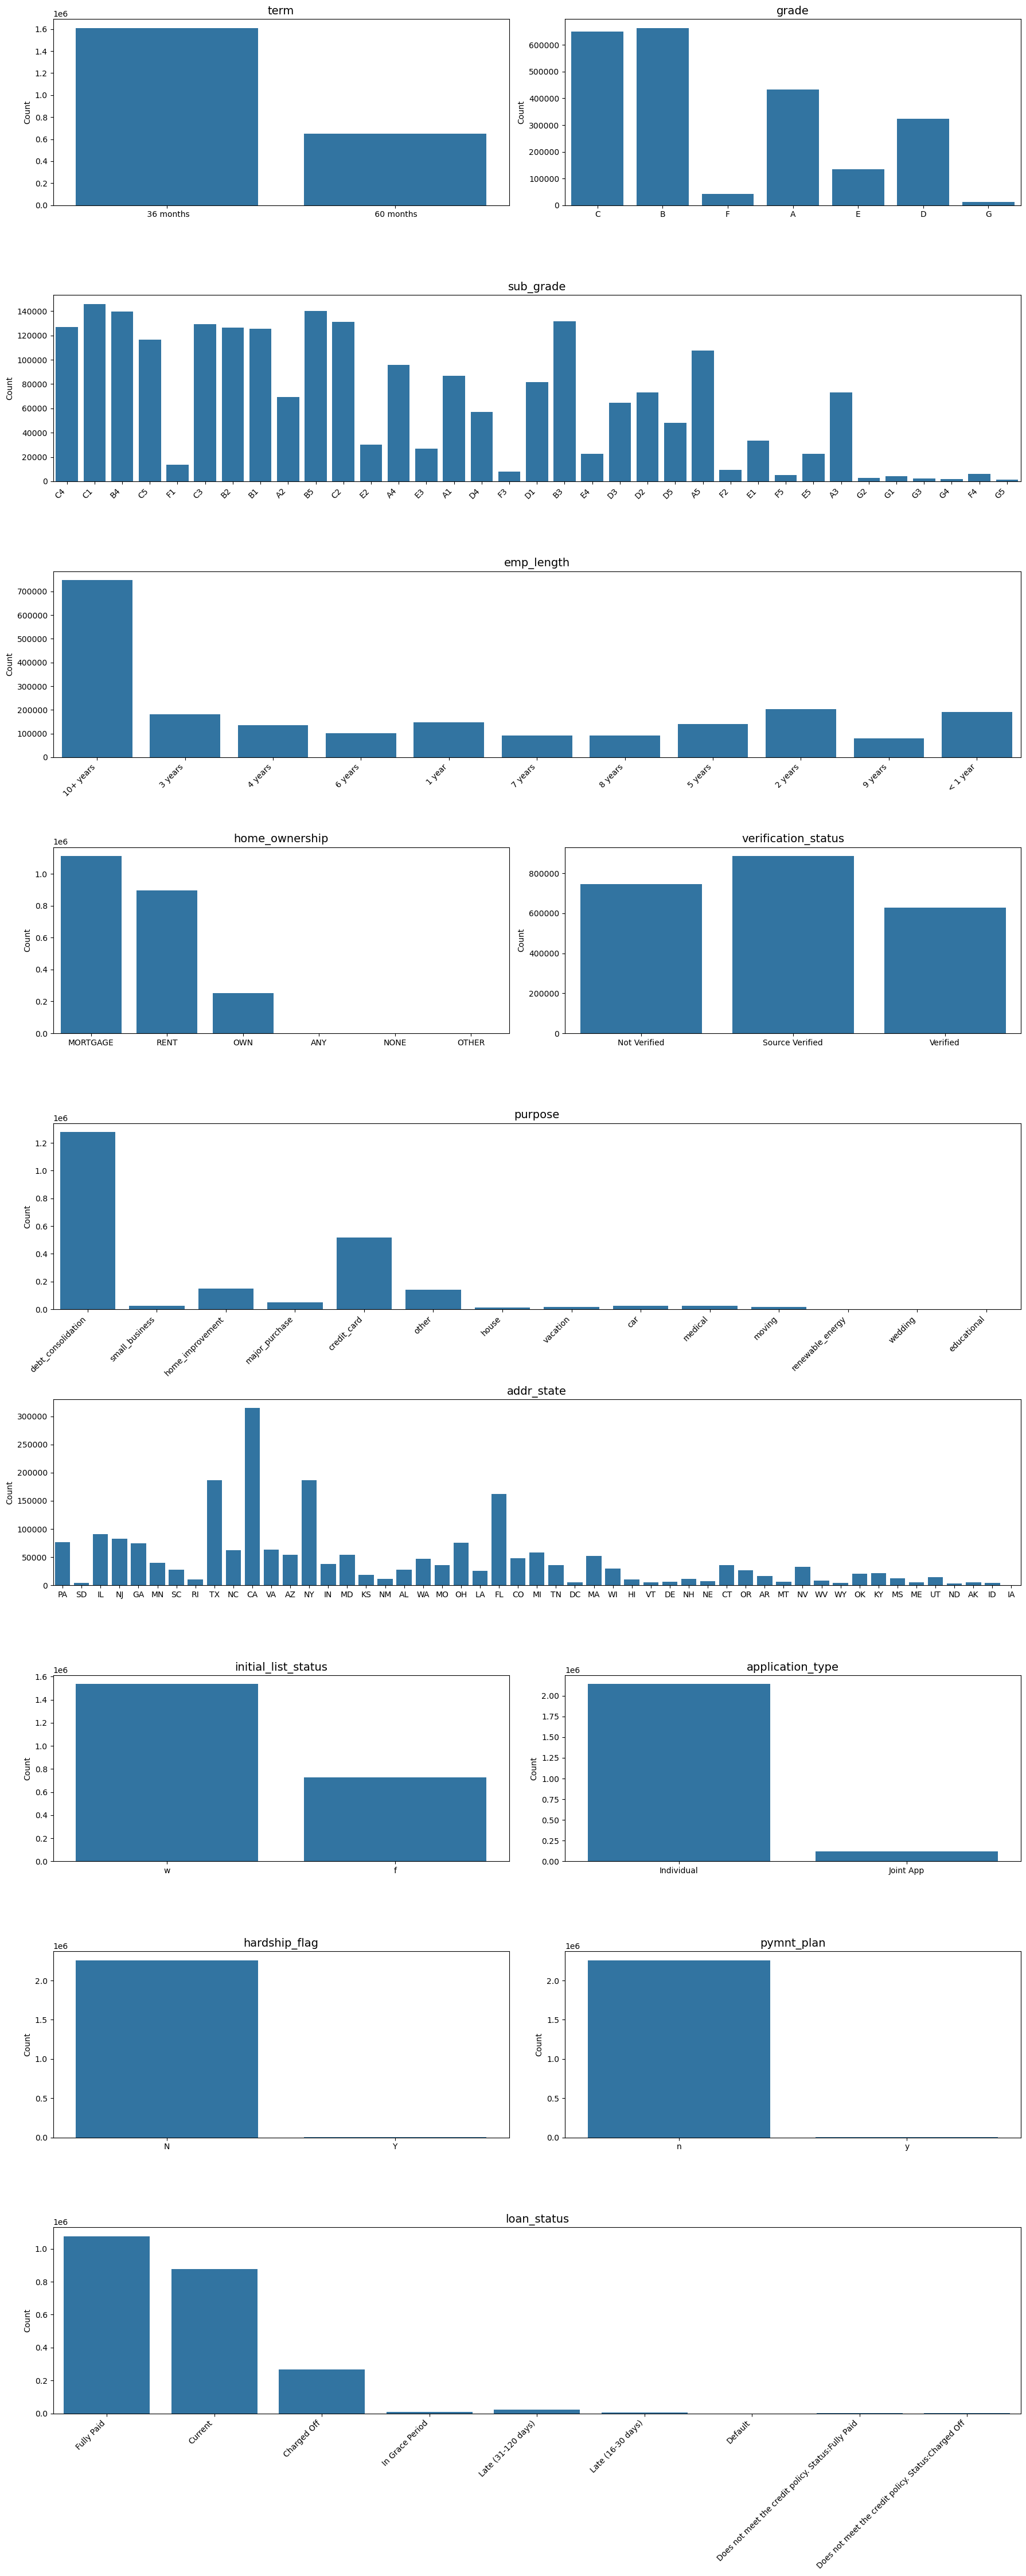

In [4]:
row_1 = ["term", "grade"]
row_2 = ["sub_grade"]
row_3 = ["emp_length"]
row_4 = ["home_ownership", "verification_status"]
row_5 = ["purpose"]
row_6 = ["addr_state"]
row_7 = ["initial_list_status", "application_type"]
row_8 = ["hardship_flag", "pymnt_plan"]
row_9 = ["loan_status"]

rows_list = [row_1, row_2, row_3, row_4, row_5, row_6, row_7, row_8, row_9]
n_rows = len(rows_list)

plt.figure(figsize=(18, n_rows * 5))

for r, row_cols in enumerate(rows_list):
    for c, col in enumerate(row_cols):
        if len(row_cols) == 1:
            ax = plt.subplot(n_rows, 1, r + 1)
        else:
            ax = plt.subplot(n_rows, 2, r * 2 + c + 1)
        sns.countplot(
            x=df[col],
            ax=ax,
        )

        plt.title(col, fontsize=14)
        plt.xlabel("")
        plt.ylabel("Count")
        if df[col].nunique() > 8:
            if col != "addr_state":
                plt.xticks(rotation=45, ha="right")
        else:
            plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

The portfolio is heavily skewed toward Prime and Near-Prime borrowers seeking short-term debt consolidation. The "Ideal Customer" and the biggest profit driver is a stable, employed individual looking to refinance existing debt into a 3-year loan.


1. Loan Terms (`term`)
- **Observation:** The vast majority of loans are 36 months (3 years), with a smaller segment at 60 months.
- **Insight:** Borrowers prefer shorter commitments.



2. Risk Grades (`grade`)
- **Observation:** The portfolio is heavily weighted toward Grades B and C, followed by A. There is very little volume in sub-prime grades (F and G).
- **Insight:** This is a "Prime" and "Near-Prime" portfolio. The bank is conservative.



3. Employment Stability (`emp_length`)
- **Observation:** The distribution is bimodal. The largest group by far is 10+ years, but there is also a notable spike at < 1 year.
- **Insight:** You have two distinct customer types: the "Stable Veteran" and the "New Entrant."



4. Home Ownership (`home_ownership`)
- **Observation:** Borrowers are split almost evenly between MORTGAGE and RENT. Very few own their homes outright ("OWN").
- **Insight:** Renters and Mortgage holders have different cash flow constraints.



5. Loan Purpose (`purpose`)
- **Observation:** Debt Consolidation is the overwhelming use case (>50%), followed by Credit Cards.
- **Insight:** This is the most critical insight for Pricing Elasticity. These borrowers are math-oriented; they are taking a loan specifically to lower their interest rates.



6. Verification (`verification_status`)
- **Observation:** A significant portion of incomes are "Not Verified."
- **Insight:** This represents hidden risk.



7. Loan Purpose (`purpose`) Reiteration
- **Observation:** "Debt Consolidation" is the dominant use case (>50%), followed by "Credit Card."
- **Insight:** Applicants are primarily refinancing to lower rates. They are highly price-sensitive, making elasticity modeling critical for conversion.



8. Geographic Distribution (`addr_state`)
- **Observation:** High concentration in populous states (CA, NY, TX, FL).
- **Insight:** Concentration Risk. A regional economic downturn in a key state like CA could disproportionately impact the entire portfolio.



9. Hardship & Payment Plans (`hardship_flag`, `pymnt_plan`)
- **Observation:** Nearly 100% of values are "No." "Yes" appears only in rare, distressed cases.
- **Insight:** Data Leakage Warning. These flags occur after a loan is issued. They must be dropped to prevent the model from "cheating" with future information.



10. Target Variable (`loan_status`)
- **Observation:** The dataset is imbalanced, with "Fully Paid" significantly outnumbering "Charged Off."


## Numeric Variables

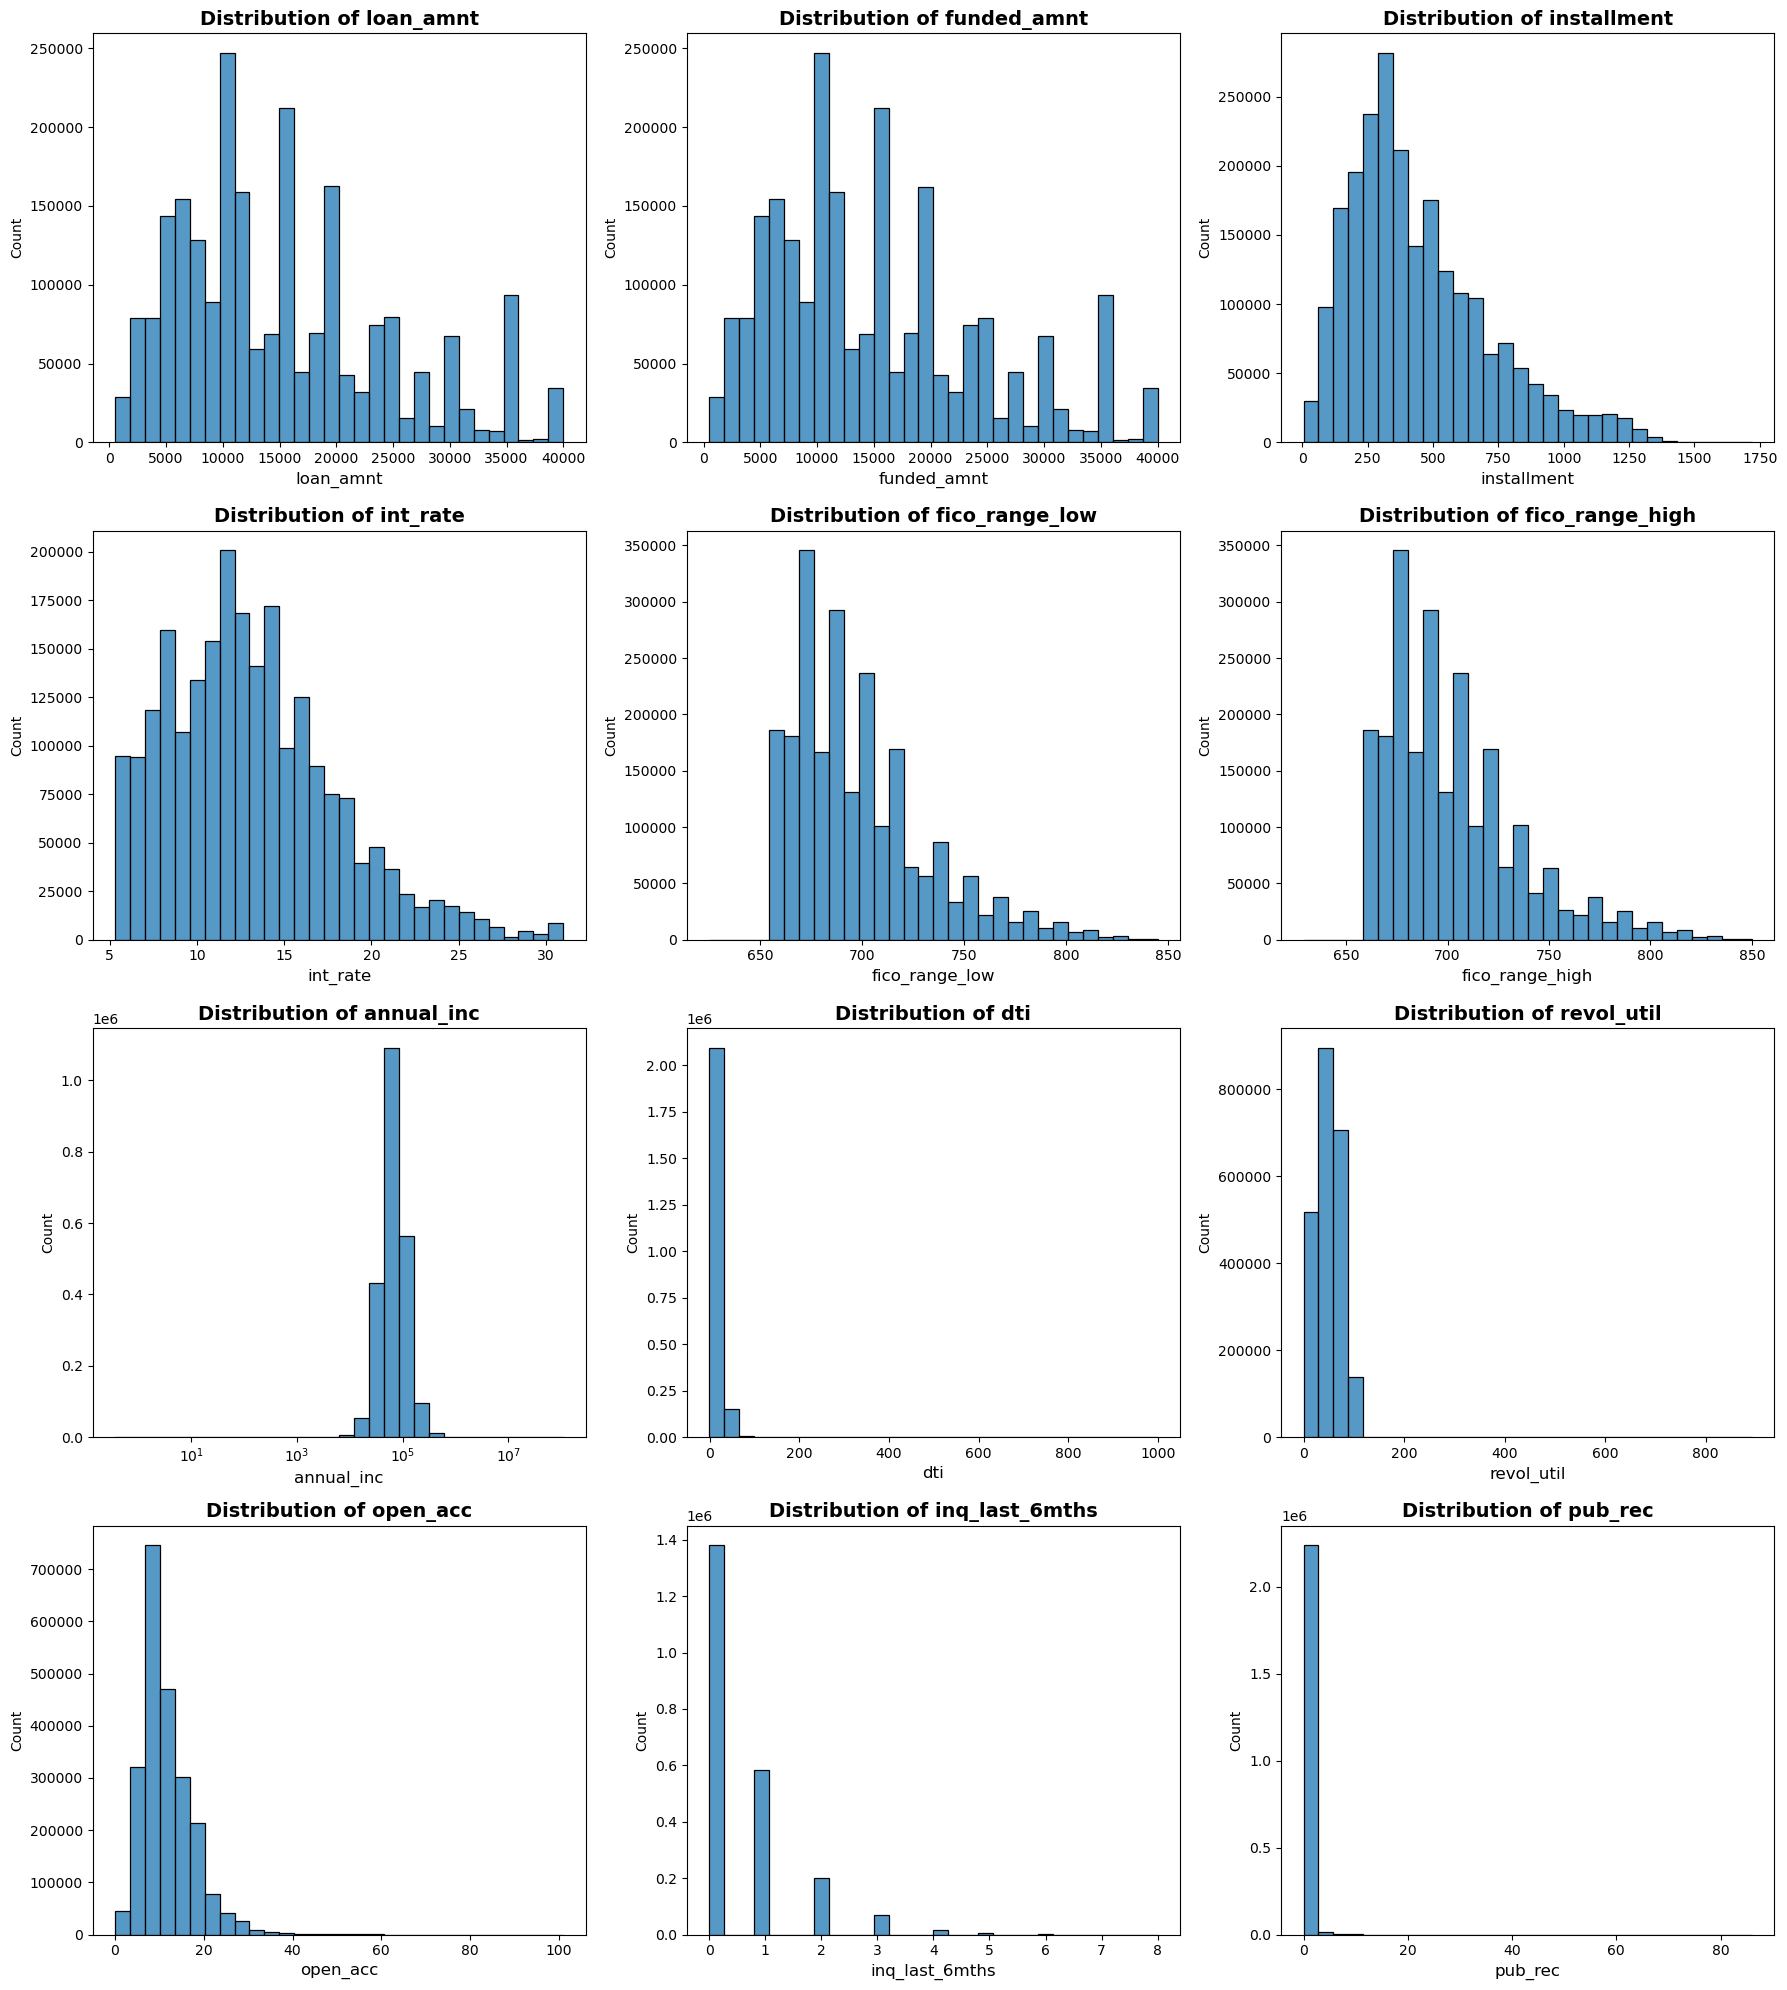

In [ ]:
layout_groups = [
    ["loan_amnt", "funded_amnt", "installment"],  # Row 1: Structure
    ["int_rate", "fico_range_low", "fico_range_high"],  # Row 2: Price/Score
    ["annual_inc", "dti", "revol_util"],  # Row 3: Capacity
    ["open_acc", "inq_last_6mths", "pub_rec"],  # Row 4: History
]

fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for i, row_cols in enumerate(layout_groups):
    for j, col in enumerate(row_cols):
        ax = axes[i, j]

        is_log = col == "annual_inc"

        sns.histplot(df[col], ax=ax, log_scale=is_log, bins=30)

        ax.set_title(f"Distribution of {col}", fontsize=14, fontweight="bold")
        ax.set_xlabel(col, fontsize=12)
        ax.tick_params(axis="both", labelsize=10)

        if col in ["pub_rec", "inq_last_6mths", "open_acc"]:
            if df[col].nunique() < 20:
                ax.set_xticks(range(int(df[col].max()) + 1))

plt.tight_layout()
plt.show()

The data paints a picture of a "Prime / Near-Prime" portfolio with strict policy limits. The bank focuses on borrowers with FICO scores above 660, caps loans at $35k-$40k, and manages risk through distinct pricing tiers (visible in the interest rate peaks).


1. Loan Structure (Row 1)
**Variables:** `loan_amnt`, `funded_amnt`, `installment`


- **Psychological Thresholds:** The `loan_amnt` and `funded_amnt` charts show distinct "spikes" at $10,000, $15,000, $20,000, and $35,000. Borrowers overwhelmingly prefer round numbers.  

- **Policy Caps:** The distribution stops abruptly around $35,000 (with a small tail to $40k). This indicates a hard internal policy limit on unsecured personal loan sizes.

- **Installment Correlation:** The installment distribution mirrors `loan_amnt`, confirming that most loans are standard amortizing products without balloons or unusual structures.


2. Price & Credit Score (Row 2)
**Variables:** `int_rate`, `fico_range_low`, `fico_range_high`


- **The "Pricing Tiers":** The `int_rate` histogram is multimodal (it has multiple peaks). You can see a peak around ~7%, another at ~11%, and another at ~15%.  
  **Insight:** These peaks correspond to the bank's Grade A, B, and C base rates. The long tail to the right (20%+) represents the risk premium charged to subprime borrowers.

- **The "Credit Floor":** The `fico_range_low` chart shows a hard cutoff around 660. The bank virtually ignores the subprime market (<600).

3. Borrower Capacity (Row 3)
**Variables:** `annual_inc`, `dti`, `revol_util`


- **Utilization Spread:** `revol_util` is widely spread, with a noticeable chunk of borrowers near 0% (inactive/thrifty) and another chunk pushing 80-100% (maxed out/desperate).


4. Credit History (Row 4)
**Variables:** `open_acc`, `inq_last_6mths`, `pub_rec`


- **Zero-Inflation:** `inq_last_6mths` (Recent Inquiries) and `pub_rec` (Public Records) are Zero-Inflated.  
- **Observation:** The vast majority of bars are at "0".  
- **Insight:** Having any value greater than 0 is a massive signal.



### Outlier Analysis

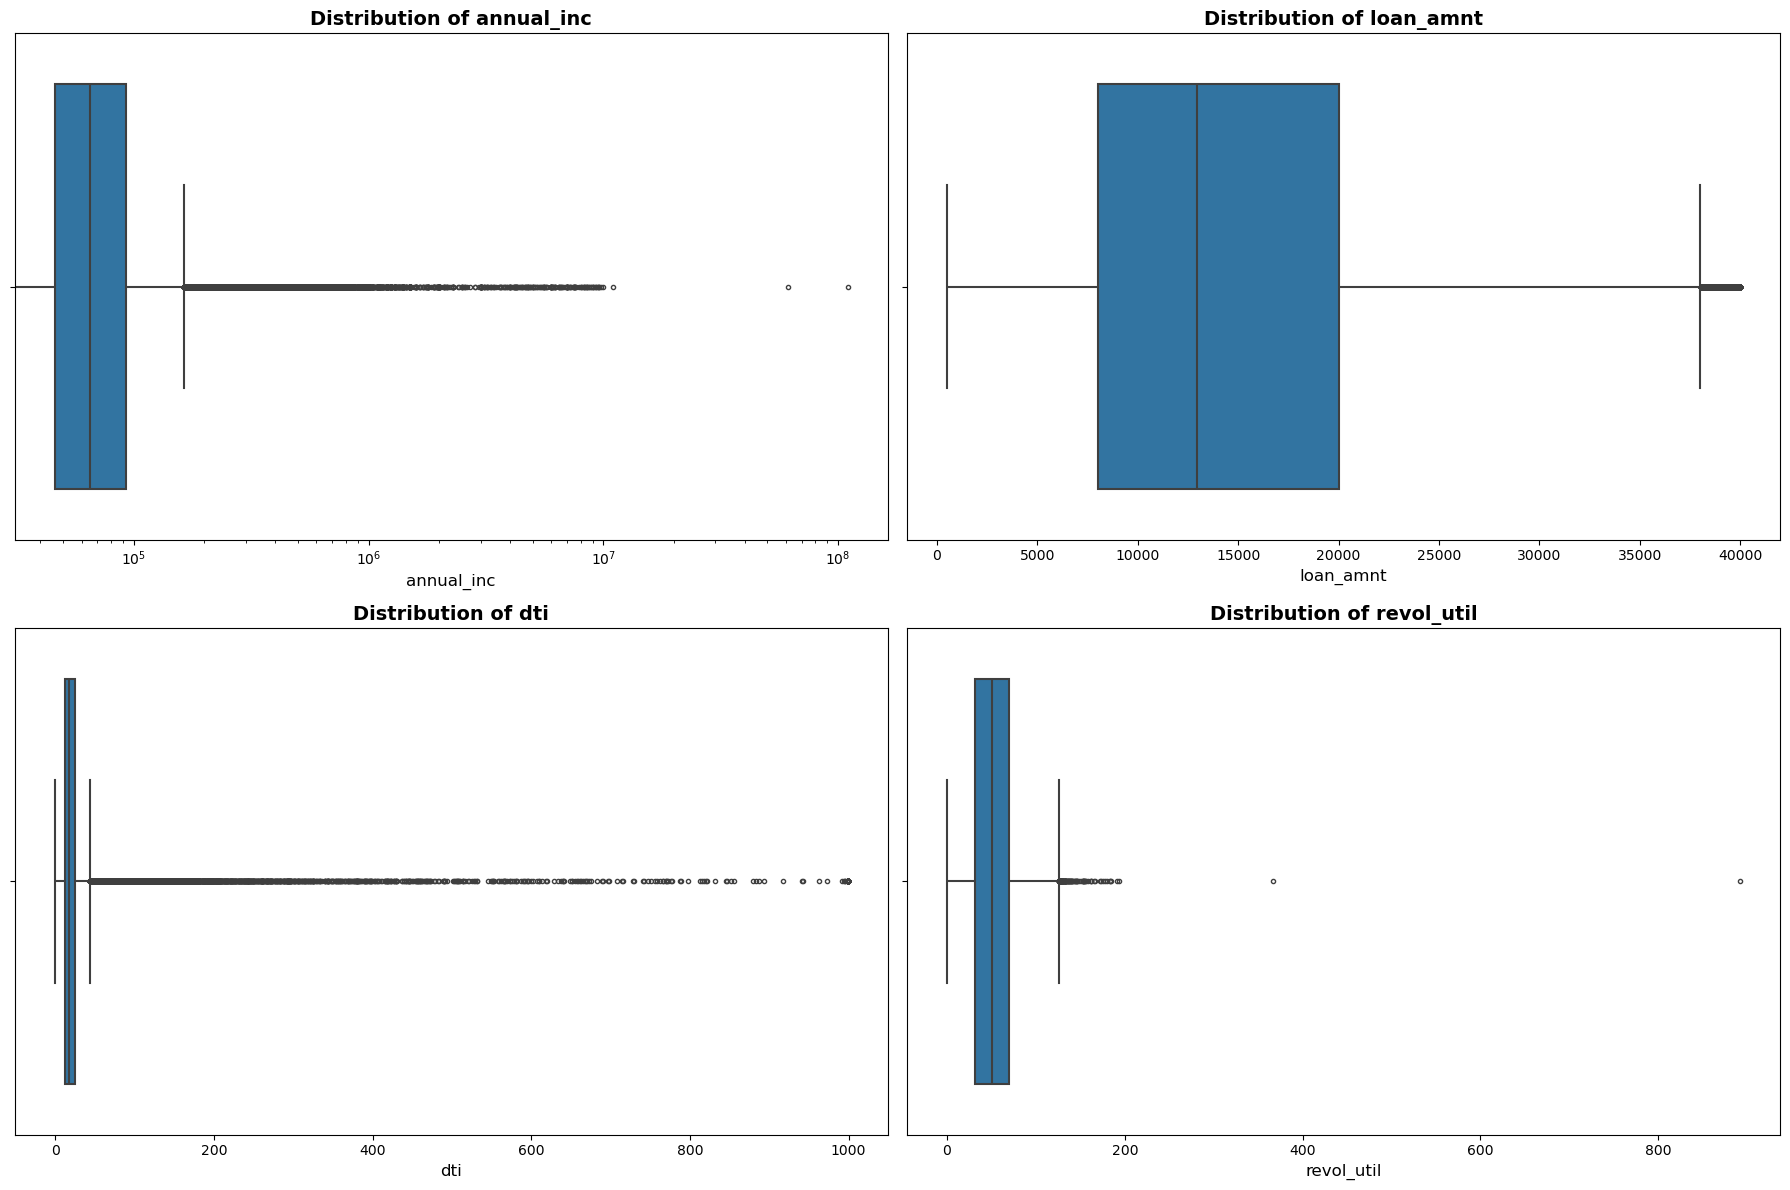

In [ ]:
cols = ["annual_inc", "loan_amnt", "dti", "revol_util"]

plt.figure(figsize=(18, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col], linewidth=1.5, fliersize=3)

    plt.title(f"Distribution of {col}", fontsize=14, fontweight="bold")

    plt.xlabel(col, fontsize=12)

    if col == "annual_inc":
        plt.xscale("log")

plt.tight_layout()
plt.show()

1. Annual Income (`annual_inc`)
- **Observation:** The plot is likely flattened by extreme outliers (millionaires), making the interquartile range (the box) look like a thin line.
- **Insight:** The raw data scale is broken. A model cannot effectively learn the difference between a $40k earner and an $80k earner when the scale extends to $5,000,000.

2. Loan Amount (`loan_amnt`)
- **Observation:** The data is well-distributed with no "wild" outliers. It typically stops abruptly around $35k or $40k.
- **Insight:** The upper limit is artificial; it represents the bank's policy cap. The bank simply does not lend more than this amount for personal loans.

3. Debt-to-Income Ratio (`dti`)
- **Observation:** The distribution has a long right tail extending beyond 30-40%.
- **Insight:** This is an Affordability Indicator. Borrowers in the "outlier" zone (>40% DTI) are leveraging themselves dangerously high. They have very little monthly cash flow buffer to absorb a shock (like a car repair), making default likely.

4. Revolving Utilization (`revol_util`)
- **Observation:** This variable (Credit Card Balance / Credit Limit) typically ranges from 0% to 100%, but you will often see "outliers" > 100%.
- **Insight:**
  - **> 80%:** Signals financial distress. The borrower has maxed out their cards and is likely taking this loan to bail themselves out. High risk.  
  - **> 100%:** Signals limit breaches. The borrower is currently over-limit, which is a massive red flag for default.  
  - **0%:** Can sometimes indicate an inactive user (thin file), which brings its own type of risk (unknown behavior).


# Target Variable Analysis

We transform `loan_status` into a binary default indicator.

Bank-style PD definition:
Default = 1 if DPD / Charged Off / Bad Loan, else 0.

Overall default rate: 13.41%


C:\Users\parth\AppData\Local\Temp\ipykernel_14220\873360513.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Default', 'Default'])


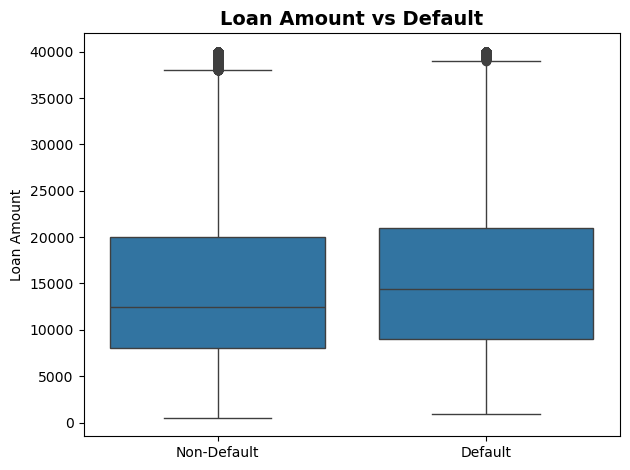

In [ ]:
default_map = {
    "Charged Off": 1,
    "Default": 1,
    "Late (31-120 days)": 1,
    "Late (16-30 days)": 1,
    "In Grace Period": 1,
    # Non-default classes
    "Fully Paid": 0,
    "Current": 0,
}

df["default"] = df["loan_status"].map(default_map)
default_rate = df["default"].mean()
print(f"Overall default rate: {default_rate:.2%}")


ax = sns.boxplot(x="default", y="loan_amnt", data=df)

ax.set_title("Loan Amount vs Default", fontsize=14, fontweight="bold")
ax.set_xlabel("")
ax.set_ylabel("Loan Amount")

ax.set_xticklabels(["Non-Default", "Default"])

plt.tight_layout()
plt.show()

Loan Amount vs Default (`loan_amnt` vs `default`)

**Observation**: The distribution of loan amounts looks very similar for both non-defaulted (0) and defaulted (1) loans. The median shifts slightly upward for defaulted borrowers, but the interquartile ranges and overall spread remain almost identical. Both groups share the same upper boundary around $35k–$40k, and both show many high-value outliers near the lending cap.

**Insight**: Loan amount by itself does not materially separate defaulters from non-defaulters. The similarity comes from LendingClub’s underwriting constraints loan sizes are capped by policy rather than borrower quality. Since everyone is constrained to the same max limit, the model cannot rely on raw loan size as a strong predictor of default risk.

At best, loan amount may provide weak indirect signals (slightly higher exposure = slightly higher risk), but it needs to be combined with other drivers like interest rate, income, DTI, and credit grade to become meaningful.

# Bivariate Analysis (Feature vs Default)

These specific variables were selected because they represent the fundamental pillars of credit risk. In the banking industry, this is often referred to as the **“5 Cs of Credit”** framework.

When performing an initial Bivariate Analysis, you **don’t** want to look at all 100+ variables at once. You start with the **“Big Hitters”** - the variables that tell you the most about a borrower’s **Ability** and **Willingness** to repay.

Below is the breakdown of why each variable was chosen:



#### 1. **The “Conditions” (Loan Structure)**  
**Variables:** `int_rate`, `term`, `grade`  

**Why:** These are the levers the bank controls.

- **Grade / Int Rate:**  
  These represent the bank’s internal assessment of borrower risk.  
  If the default rate does **not** increase as Grade worsens (A → G), then the bank’s pricing model is fundamentally broken.  
  We analyze this to validate **Pricing Efficiency**.

- **Term:**  
  Time increases risk. A 5-year loan almost always carries more default risk than a 3-year loan.  
  We analyze whether **longer terms = higher default rates** (they usually do).


#### 2. **The “Capacity” (Ability to Repay)**  
**Variables:** `dti` (Debt-to-Income), `annual_inc`  

**Why:** These capture the borrower’s financial strength.

- **DTI:**  
  One of the most important affordability metrics. It answers:  
  **“After paying their other debts, does this borrower have enough money left for us?”**  
  High DTI = thin cash flow buffer = high risk.

- **Income:**  
  High income doesn’t guarantee repayment, but low income nearly guarantees instability.  
  We analyze income to identify the **“Danger Zone”** (e.g., borrowers earning < \$30k).


#### 3. **The “Character” & “Collateral” (Stability)**  
**Variable:** `home_ownership`  

**Why:** This acts as a proxy for stability and asset strength.

- **Home Ownership:**  
  Homeowners generally have more stability, more assets, and are statistically less likely to default compared to renters.  
  It serves as a **behavioral and stability indicator**.


#### **Summary**

We focused on these 6 variables because they answer the three most critical business questions in credit risk:

1. **Are we pricing correctly?**  
   (`grade`, `int_rate`)

2. **Can they afford it?**  
   (`annual_inc`, `dti`)

3. **Are they stable?**  
   (`home_ownership`)

These variables form the foundation of any meaningful credit risk analysis.

![alt text ](image1.png h) 

Note: For the actual Machine Learning Model (the Pricing Engine), we will use many more variables (e.g., inquiries, revolving utilization, purpose, verification status). But for this manual visual analysis, we start with these core drivers to get a "gut check" on the portfolio.


Target Distribution:
default
0.0    0.865872
1.0    0.134128
Name: proportion, dtype: float64


C:\Users\parth\AppData\Local\Temp\ipykernel_14220\1238808603.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['Non-Default', 'Default'])
C:\Users\parth\AppData\Local\Temp\ipykernel_14220\1238808603.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(['Non-Default', 'Default'])
C:\Users\parth\AppData\Local\Temp\ipykernel_14220\1238808603.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(['Non-Default', 'Default'])


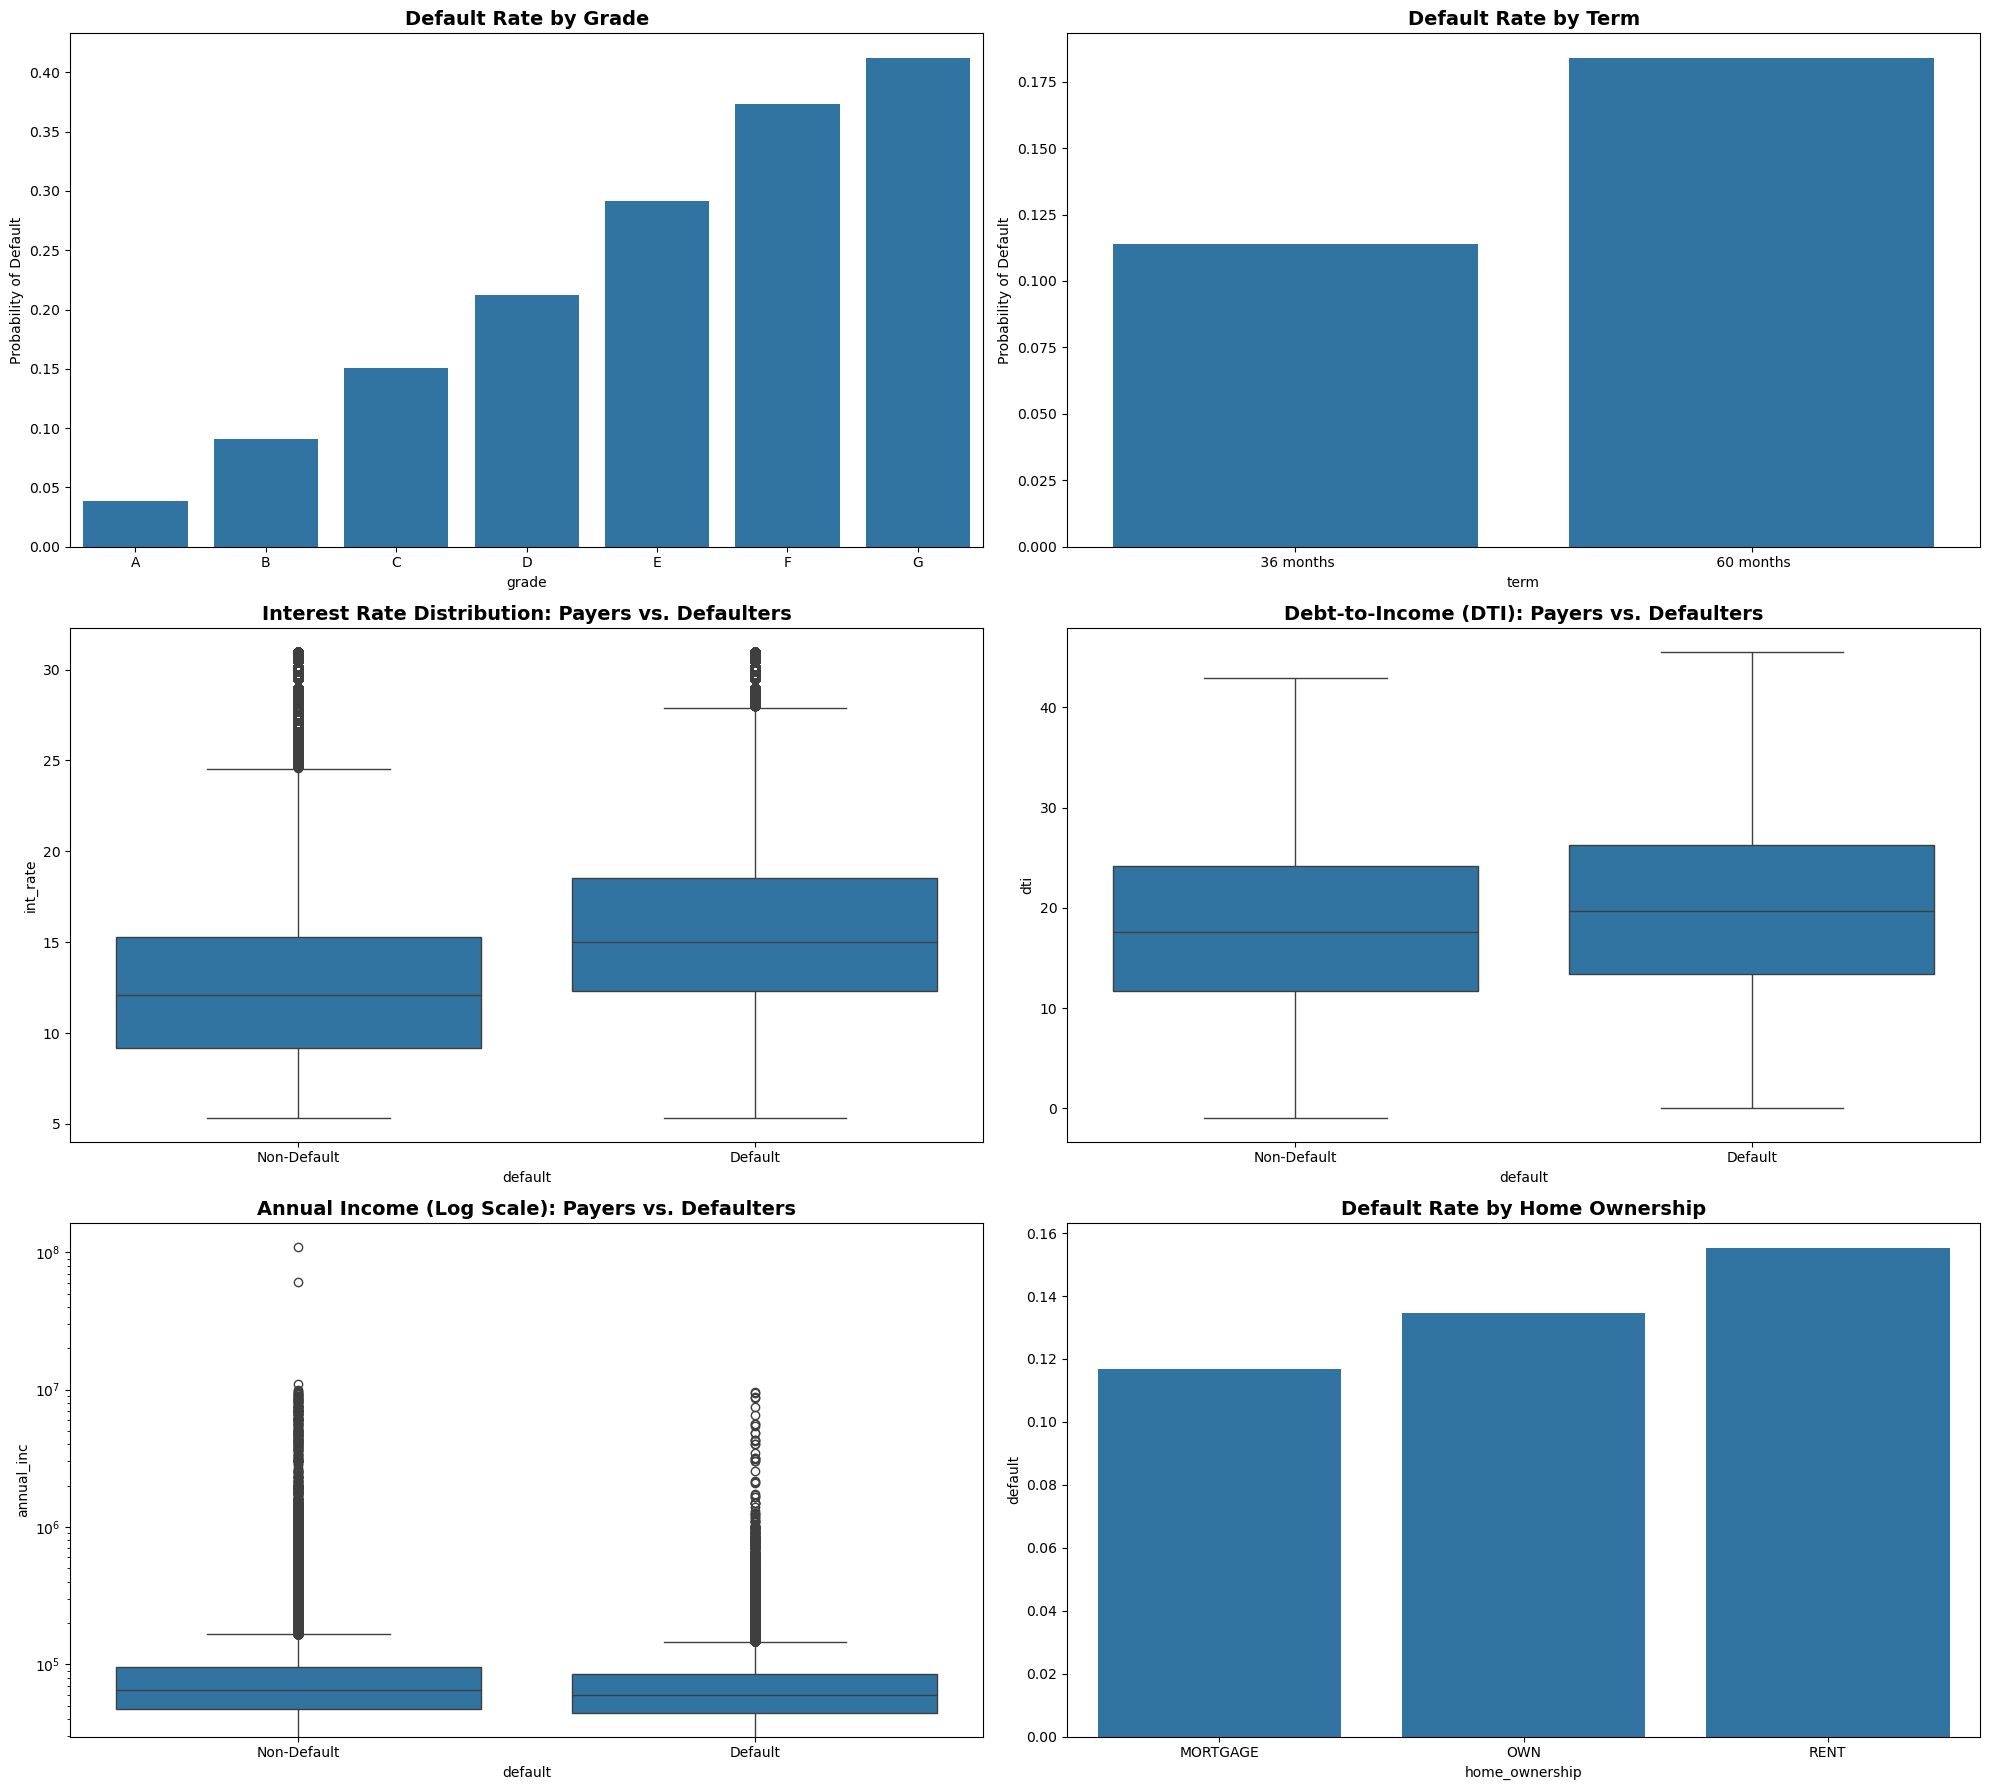

In [ ]:
df = df.dropna(subset=["default"])

print("Target Distribution:")
print(df["default"].value_counts(normalize=True))

fig = plt.figure(figsize=(20, 18))


ax1 = plt.subplot(3, 2, 1)
grade_risk = df.groupby("grade")["default"].mean().reset_index()
sns.barplot(
    x="grade",
    y="default",
    data=grade_risk,
    ax=ax1,
    order=sorted(grade_risk["grade"].unique()),
)
ax1.set_title("Default Rate by Grade", fontsize=14, fontweight="bold")
ax1.set_ylabel("Probability of Default")


ax2 = plt.subplot(3, 2, 2)
term_risk = df.groupby("term")["default"].mean().reset_index()
sns.barplot(x="term", y="default", data=term_risk, ax=ax2)
ax2.set_title("Default Rate by Term", fontsize=14, fontweight="bold")
ax2.set_ylabel("Probability of Default")


ax3 = plt.subplot(3, 2, 3)
sns.boxplot(x="default", y="int_rate", data=df, ax=ax3)
ax3.set_title(
    "Interest Rate Distribution: Payers vs. Defaulters", fontsize=14, fontweight="bold"
)
ax3.set_xticklabels(["Non-Default", "Default"])


ax4 = plt.subplot(3, 2, 4)
sns.boxplot(
    x="default", y="dti", data=df, showfliers=False, ax=ax4
)  # Hiding extreme outliers for clarity
ax4.set_title(
    "Debt-to-Income (DTI): Payers vs. Defaulters", fontsize=14, fontweight="bold"
)
ax4.set_xticklabels(["Non-Default", "Default"])


ax5 = plt.subplot(3, 2, 5)
sns.boxplot(x="default", y="annual_inc", data=df, ax=ax5)
ax5.set_yscale("log")
ax5.set_title(
    "Annual Income (Log Scale): Payers vs. Defaulters", fontsize=14, fontweight="bold"
)
ax5.set_xticklabels(["Non-Default", "Default"])


ax6 = plt.subplot(3, 2, 6)
home_risk = df.groupby("home_ownership")["default"].mean().reset_index()

home_risk = home_risk[home_risk["home_ownership"].isin(["RENT", "MORTGAGE", "OWN"])]
sns.barplot(x="home_ownership", y="default", data=home_risk, ax=ax6)
ax6.set_title("Default Rate by Home Ownership", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

1. Default Rate by `grade`

- Default rates rise monotonically from Grade A to G, with A the safest and G the riskiest.
- This confirms the bank’s grading system aligns well with realized risk and that the target variable is well-structured for modeling.


2. Default Rate by `term`

- 36‑month loans default at around 11%, while 60‑month loans default near 19%.
- Longer terms carry more uncertainty and exposure, so term will be a strong structural risk predictor.


3. `interest_rate`: Payers vs Defaulters

- Defaulters have visibly higher median and upper‑quartile interest rates compared with payers.
- This shows pricing partially captured their risk, but not enough to offset default probability; interest rate is effectively a built‑in risk signal.


4. `dti` and Income

- Median DTI is similar across groups, but defaulters show a fatter upper tail, especially beyond 30–40%.
- On a log income scale, defaulters cluster more in lower‑income bands, indicating tight cash flow and weak buffers drive affordability risk.


5. `home_ownership` and Stability

- Default rates roughly follow: Mortgage ≈ 12%, Own ≈ 14%, Rent ≈ 16%.
- Renters appear least anchored financially, while homeowners (mortgage or own) show more stability and lower risk.


6. Summary Risk Dimensions

- Structural risk: Grade and term clearly separate risk levels.
- Affordability risk: Interest rate, DTI, and income capture repayment capacity.
- Stability risk: Home ownership status distinguishes more transient, higher‑risk renters from more anchored owners. Together, these patterns are monotonic, intuitive, and highly model‑friendly.

# Correlation Analysis

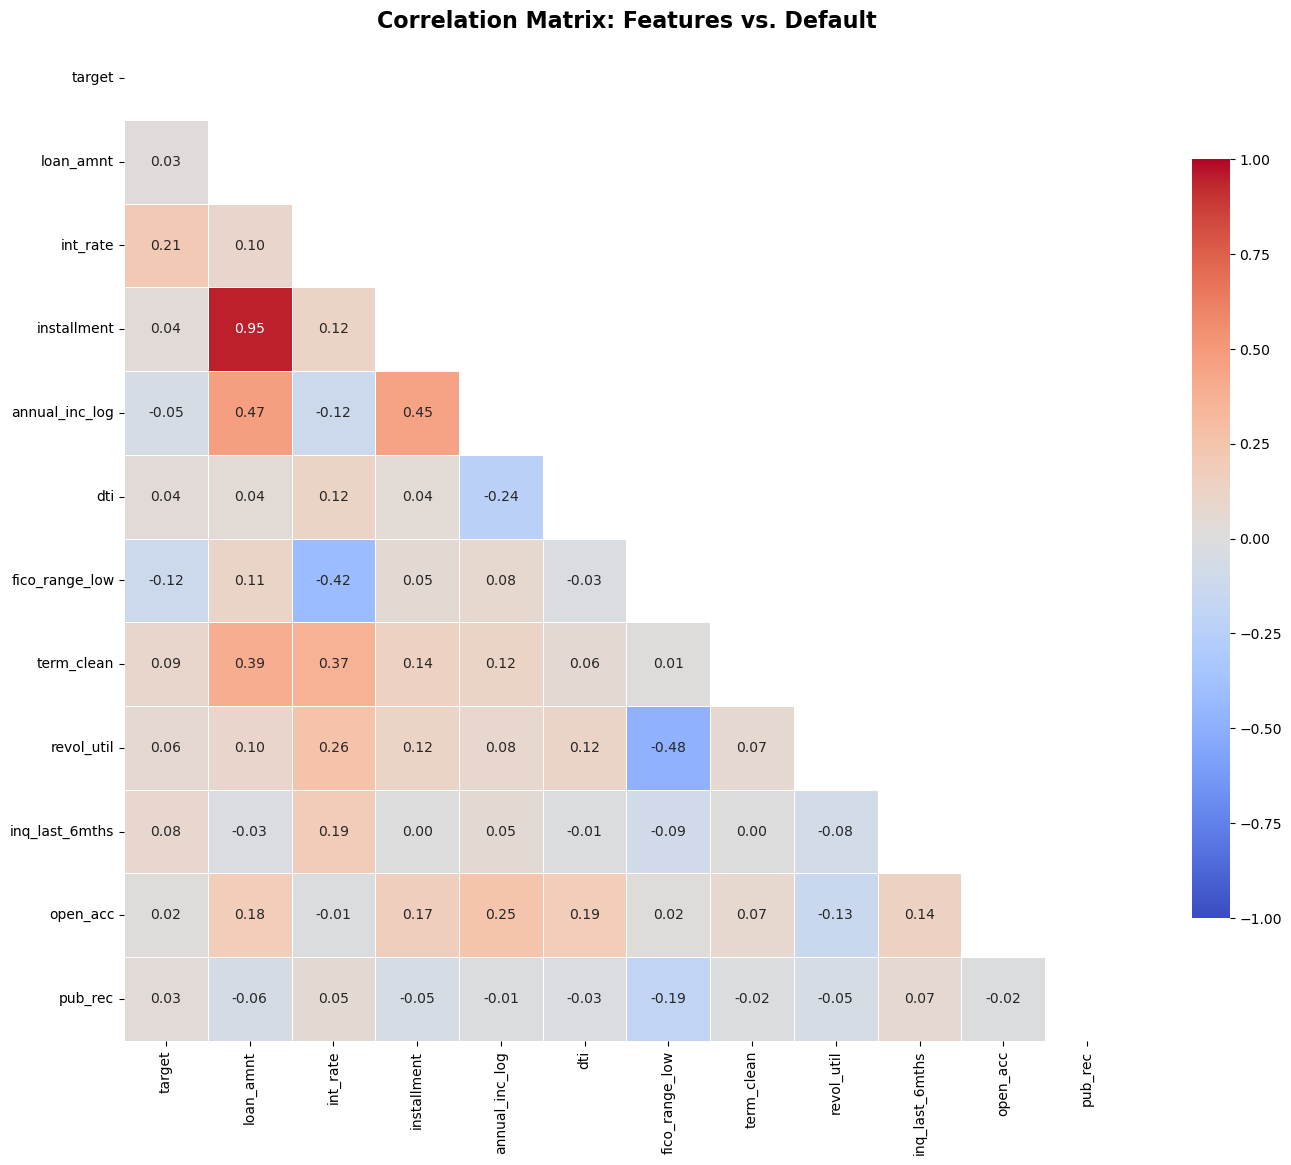

Correlation with Target Variable (Default):
target            1.000000
int_rate          0.212050
term_clean        0.093248
inq_last_6mths    0.084137
revol_util        0.062869
dti               0.037286
installment       0.035205
pub_rec           0.032573
loan_amnt         0.029794
open_acc          0.017992
annual_inc_log   -0.053437
fico_range_low   -0.122362
Name: target, dtype: float64

Check for Multicollinearity (High Correlation betwen features):
Loan Amount vs. Installment: 0.9456


In [ ]:
df["target"] = df["loan_status"].map(default_map)


def clean_term(x):
    if isinstance(x, str):
        return int(x.strip().replace(" months", ""))
    return x


df["term_clean"] = df["term"].apply(clean_term)


df["annual_inc_log"] = np.log1p(df["annual_inc"])

corr_cols = [
    "target",
    "loan_amnt",
    "int_rate",
    "installment",
    "annual_inc_log",
    "dti",
    "fico_range_low",
    "term_clean",
    "revol_util",
    "inq_last_6mths",
    "open_acc",
    "pub_rec",
]

df_corr = df[corr_cols].dropna()

corr_matrix = df_corr.corr()

plt.figure(figsize=(14, 12))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
)

plt.title("Correlation Matrix: Features vs. Default", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


print("Correlation with Target Variable (Default):")
print(corr_matrix["target"].sort_values(ascending=False))

print("\nCheck for Multicollinearity (High Correlation betwen features):")
print(f"Loan Amount vs. Installment: {corr_matrix.loc['loan_amnt', 'installment']:.4f}")

The `target` variable (likely representing the default status) shows primarily low-to-moderate correlations with the features:

* Positive Correlations with `target` (Default Risk):
    * `int_rate` (Interest Rate) shows the highest positive correlation with the `target` at 0.21. This suggests loans with higher interest rates are moderately more likely to be associated with default.

    * Other features showing low positive correlation with the `target` include `term_clean` (0.09), `inq_last_6mths` (0.08), `revol_util` (0.05), `installment` (0.04), `dti` (0.04), `loan_amnt` (0.03), and `pub_rec` (0.03).

* Negative Correlations with `target` (Default Risk):
    
    * `fico_range_low` (Lower FICO Score Range) shows the highest negative correlation with the `target` at -0.12. This is an expected relationship: higher credit scores (or in this case, a higher value for the lower bound of the FICO range) tend to correlate with a lower probability of default.
    
    * `annual_inc_log` (Log of Annual Income) shows a slight negative correlation of -0.05.

Strongest Feature-to-Feature Correlations

The matrix highlights several strong relationships among the independent variables:

* Extremely High Positive Correlation: The strongest relationship shown is between `loan_amnt` (Loan Amount) and `installment` (Installment amount), with a correlation coefficient of 0.95. This high value (represented by dark red) indicates that the size of the loan is highly predictive of the required installment payment.

* Strong Negative Correlations:
    
    * `loan_amnt` (Loan Amount) and `annual_inc_log` (Log of Annual Income) have a strong negative correlation of -0.47.
    
    * `int_rate` (Interest Rate) and `fico_range_low` have a strong negative correlation of -0.42. This suggests that higher credit scores generally result in lower interest rates.
Other Notable Correlations

• `int_rate` also shows moderate positive correlations with `loan_amnt` (0.41), `term_clean` (0.37), and `revol_util` (0.26).

• `term_clean` has a moderate positive correlation with `installment` (0.34) and `loan_amnt` (0.39).

### Feature Engineering Opportunities

Based on the EDA, we have identified specific transformations to improve model performance:

* **Log Transformation:**
    * `annual_inc`: The variable is highly right-skewed with extreme outliers (millionaires). Log transformation is mandatory to normalize the distribution.
    * `revol_bal`: To handle the wide variance in credit balances.

* **Binning & Caping:**
    * `dti`: Create a "High Risk" flag or cap values > 40% (the "Danger Zone").
    * `revol_util`: Bin into categories (e.g., 0-30%, 30-80%, >100% "Over Limit").

* **Derived Ratios:**
    * `loan_to_income`: Calculate `loan_amnt / annual_inc` to measure leverage better than loan amount alone.
    * `credit_history_length`: Convert `earliest_cr_line` to a numeric "Months of History" feature (e.g., `current_date - earliest_cr_line`).

* **Categorical Encoding:**
    * **Ordinal Encoding:** Convert `grade` (A-G) and `sub_grade` (A1-G5) into numeric scales (0-35) to capture the monotonic risk relationship.
    * **One-Hot Encoding:** Apply to `purpose`, `home_ownership`, and `verification_status`.

* **Interaction Terms:**
    * `verification_status * fico_score`: To solve the "Verification Paradox" (where verified users seemed riskier). This interaction helps the model understand that verification is a proxy for borderline applicants.

### Weight of Evidence (WOE) & Information Value (IV)
*(Optional Step for PD Modeling)*

This technique can be used to mathematically select the strongest features before training.
* **WOE:** Transforms categorical variables into "Risk Strength" numbers based on the ratio of Good/Bad customers in each bin.
* **IV:** Ranks variables by their predictive power. Based on our EDA, we expect `sub_grade` and `int_rate` to have the highest IV scores.


### Findings Summary


**1. Top Predictive Features ( The Signal):**
* **Primary Drivers:** `grade`/`sub_grade`, `int_rate`, and `fico_range_low` are the strongest predictors of default.
* **Secondary Drivers:** `dti` (debt load) and `term` (60-month loans are significantly riskier).

**2. Critical Data Issues (The Noise):**
* **Data Leakage:** `hardship_flag` and `pymnt_plan` are 100% predictive of default but occur *after* the loan is issued. **Action:** Must drop these columns.
* **Broken Scales:** `annual_inc` has massive outliers that distort the model. **Action:** Log-transform or Winsorize.
* **Redundancy:** `installment` is perfectly correlated with `loan_amnt` and `term`. **Action:** Drop `installment` to prevent multicollinearity.

**3. Strategic Anomalies:**
* **Verification Paradox:** "Verified" income applicants have higher default rates, likely because verification is triggered for riskier profiles.
* **Zero-Inflation:** `pub_rec` and `inq_last_6mths` are mostly zeros. **Action:** Create binary flags (`has_public_record`) instead of treating them as continuous linear variables.

**4. Modeling Assumptions:**
* We will focus on **Individual Applications** only (removing the negligible Joint App volume).
* We will apply **Class Weighting** to handle the imbalance between "Fully Paid" (Majority) and "Charged Off" (Minority).

## Synthesis & Strategy

This section synthesizes the findings from the Exploratory Data Analysis (EDA) into a concrete action plan for the modeling phase. It defines how we will handle data quality issues, engineer features to capture risk, and structure the machine learning pipeline.

#### **Data Cleaning & Preprocessing Strategy**
* **Leakage Removal:**
    * **Action:** Drop `hardship_flag` and `pymnt_plan`.
    * **Rationale:** These variables represent post-origination events (financial distress occuring *after* the loan is issued). Including them would cause "Data Leakage," leading to an artificially high model score that fails in production.
* **Outlier Management:**
    * **Action:** Apply `np.log1p()` transformation to `annual_inc`.
    * **Rationale:** The EDA revealed massive income outliers (up to $10M+) that distort the scale. Log transformation normalizes the distribution, allowing the model to learn from the majority of borrowers effectively.
* **Redundancy Removal (Multicollinearity):**
    * **Action:** Drop `installment`, `fico_range_high`, and `funded_amnt`.
    * **Rationale:**
        * `installment` is mathematically derived from `loan_amnt`, `term`, and `int_rate`.
        * `fico_range_high` is perfectly correlated with `fico_range_low`.
        * `funded_amnt` provides duplicate signal to `loan_amnt`.
        * Removing these prevents multicollinearity and keeps the model stable.

#### **Feature Engineering Strategy**
* **Ordinal Encoding:**
    * **Action:** Convert `grade` and `sub_grade` into numeric scales (e.g., A1=1, A2=2... G5=35).
    * **Rationale:** The Bivariate Analysis showed a strict monotonic relationship between Grade and Default. Numeric encoding preserves this linear risk signal better than One-Hot encoding.
* **Interaction Terms:**
    * **Action:** Create `verification_status * fico_score`.
    * **Rationale:** The "Verification Paradox" showed that verified applicants appeared riskier. This interaction term helps the model understand that verification is a context-dependent proxy for borderline applicants.
* **Risk Flags (Zero-Inflation Handling):**
    * **Action:** Convert `pub_rec` and `inq_last_6mths` into binary flags (`has_public_record`, `has_recent_inquiry`).
    * **Rationale:** The histograms were heavily zero-inflated. The predictive signal is primarily in the *presence* of a record, not necessarily the count.
* **Non-Linear Transformations:**
    * **Action:** Cap `dti` at 40% (or create a `high_dti` flag) and bin `revol_util` (e.g., 0-30%, 30-80%, >80%).
    * **Rationale:** Risk increases exponentially, not linearly, at the extreme ends of these variables.

#### **Modeling Strategy**
* **Target Definition:**
    * Binary Classification: `0` = Fully Paid / Current (Safe), `1` = Charged Off / Default (Risky).
* **Imbalance Handling:**
    * The dataset is imbalanced (Majority class = Safe). We will employ **Class Weighting** (e.g., `scale_pos_weight` in XGBoost) or **SMOTE** (Synthetic Minority Over-sampling Technique) to force the model to prioritize predicting defaults.
* **Algorithm Selection:**
    * **Baseline:** Logistic Regression (for high interpretability and regulatory compliance).
    * **Challenger:** XGBoost/LightGBM (to capture non-linear relationships and maximize predictive power).